# 1- Diffusion problem with zero boundary conditions


We want to solve:
$$
\begin{align*}
    -\Delta u &= f(x,y)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We set u = $(1-x^2)(1-y^2)$ the exact solution in order to find f(x,y)
$$
\begin{align*}
    u(x, y) &= (1-x^2)(1-y^2) \\
    &= 1 -y^2 -x^2(1-y^2) \\
\end{align*}
\\
\begin{align*}
    \frac{\partial u}{\partial x}(x, y) = -2x(1-y^2) \\
\end{align*}
\\
\begin{align*}
    \frac{\partial^2u}{\partial x^2}(x,y) = -2(1-y^2)
\end{align*}
$$
So, we want to solve the following problem:
$$
\begin{align*}
    -\Delta u &= 2(1-y^2) + 2(1-x^2)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We are going to minimise:
$$
\begin{align*}
    L = \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy + \int_\Omega f(x,y)u(x,y)dx dy - \beta \frac{1}{N_{boundary}}\sum_{i=0}^{N_{boundary}}(u(x_i, y_i) - \hat{u}(x_i, y_i))^2
\end{align*}
$$
The advantage of this manufactured example is that we can compute exactly each term of the loss and know if we approximate it correctly:
$$
\begin{align*}
    \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}4x^2(1-y^2)^2dxdy \\
    &= \frac{128}{45}
\end{align*}
$$
$$
\begin{align*}
    \int_\Omega f(x,y)u(x,y)dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}(2(1-y^2)+2(1-x^2))(1-x^2)(1-y^2)dxdy \\
    &= \frac{256}{45}
\end{align*}
$$

In [81]:
# import dolfin
import sys, os
import torch
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from NeuralNetworks import fwdNN as fwd
from NeuralNetworks import residualNN as rnn
import plots

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]
        
        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3
    
class Omega2D(Dataset):
    def __init__(self, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train = self._create_points_for_training()

    def _create_points_for_training(self):
        xmin, xmax = self.x_bounds
        ymin, ymax = self.y_bounds

        x = np.random.uniform(xmin, xmax, self.n_omega)
        y = np.random.uniform(ymin, ymax, self.n_omega)
        omega_coordinates = np.column_stack((x, y))

        n_per_boundary = self.n_boundary//4
        x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
        x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
        y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
        boundary_coordinates = np.column_stack((x_boundary, y_boundary))

        return omega_coordinates, boundary_coordinates
    
    def plot(self):
        plt.scatter(self.omega_train[:, 0], self.omega_train[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_train[:, 0], self.boundary_train[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [ ]:
class ExampleOne():
    def __init__(self, hidden_size=20):
        
        self.model = fwd.FullyConnectedNetwork(input_dim=2, hidden_size=hidden_size).to(device)
        # self.model = RitzModel(input_dim=2, num_blocks=4, hidden_size=hidden_size)
        self.criterion = DeepRitzLoss()

        self.total_loss = []
        self.physical_loss1 = []
        self.physical_loss2 = []
        self.boundary_loss = []

    def train(self, n_iter):

        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.model.train()

        for iter_i in range(n_iter):
            integration_grid = Omega2D(10000, 2500)

            x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
            x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
            fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
            cl_boundary = self.cl_boundary(x_boundary).to(device)
            x_omega.requires_grad = True

            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

    def train_config2(self, n_iter):
        """
            Integration points generated only once using a uniform grid with fewer points
        """
        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.model.train()

        for iter_i in range(n_iter):
            ...

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)
    
    def f(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = 2*(1-x2**2) + 2*(1-x1**2)
        return fx
    
    def u(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        u = (1-x1**2)*(1-x2**2)
        return u
    
    def du_x1_exact(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        du_x1 = -2*x1*(1-x2**2)
        return du_x1
    
    def du_x2_exact(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        du_x2 = -2*x2*(1-x1**2)
        return du_x2

def norm_h1(x, u):
    grad_u = torch.autograd.grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), allow_unused=True, retain_graph=True)[0]
    l2_norm_u = torch.linalg.norm(u)
    l2_norm_gradu = torch.linalg.norm(grad_u)
    return torch.sqrt(l2_norm_u**2 + l2_norm_gradu**2).item()

def asses_solution(example):
    model = example.model
    model.eval()

    evaluation_grid = Omega2D()
    x_eval = torch.FloatTensor(evaluation_grid.mesh_eval).to(device)

    u_pred = (model(x_eval).cpu().detach().numpy()).reshape(101, 101)
    u_exact = (example.u(x_eval).cpu().numpy()).reshape(101, 101)

    print(np.mean(np.abs(u_exact-u_pred)))
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axes[0].imshow(u_pred, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[0].set_title('Predicted solution')
    fig.colorbar(im0, ax=axes[0], shrink=0.6)

    im1 = axes[1].imshow(u_exact, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[1].set_title('Exact solution')
    fig.colorbar(im1, ax=axes[1], shrink=0.6)

    plt.show()

In [85]:
torch.manual_seed(15)

In [86]:
model1 = ExampleOne(hidden_size=20)
model1.train(5000)

Iteration 0, loss: 16.7890567779541
Iteration 100, loss: -0.06510315090417862
Iteration 200, loss: -0.0708945244550705
Iteration 300, loss: -0.0821988433599472
Iteration 400, loss: -0.10802873969078064
Iteration 500, loss: -0.1540173888206482
Iteration 600, loss: -0.2676635682582855
Iteration 700, loss: -0.708307147026062
Iteration 800, loss: -2.5292744636535645
Iteration 900, loss: -2.7369863986968994
Iteration 1000, loss: -2.799635648727417
Iteration 1100, loss: -2.77483868598938
Iteration 1200, loss: -2.7236499786376953
Iteration 1300, loss: -2.7819714546203613
Iteration 1400, loss: -2.8179914951324463
Iteration 1500, loss: -2.8518805503845215
Iteration 1600, loss: -2.740264415740967
Iteration 1700, loss: -2.744755983352661
Iteration 1800, loss: -2.7017953395843506
Iteration 1900, loss: -2.8141350746154785
Iteration 2000, loss: -2.804412364959717
Iteration 2100, loss: -2.8143436908721924
Iteration 2200, loss: -2.8454196453094482
Iteration 2300, loss: -2.8030471801757812
Iteration 24

In [87]:
sig = 'fwd'
n_iter_adam = 5000
n_omega = 10000
n_boundary = 2500
beta = 500
model_name = f'ex1_{sig}_iter{n_iter_adam//1000}k_{n_omega}_{n_boundary}_beta{beta}.pth'
# torch.save(model1.model.state_dict(), f'./Models/{model_name}')

5.688888888888889


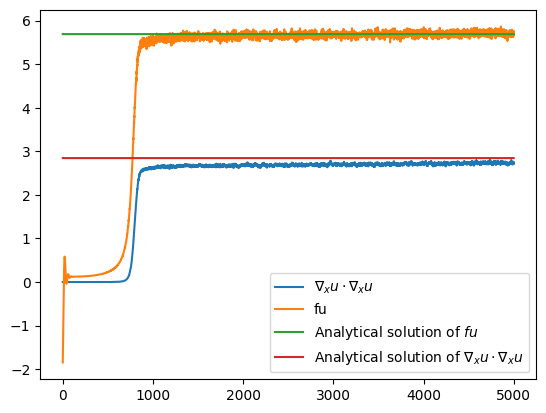

In [88]:
plt.plot(model1.physical_loss1, label=r'$\nabla_x u \cdot \nabla_x u$')
plt.plot(model1.physical_loss2, label=r'fu')
plt.plot(np.ones(len(model1.physical_loss2))*256/45, label=r'Analytical solution of $fu$')
plt.plot(np.ones(len(model1.physical_loss1))*128/45, label=r'Analytical solution of $\nabla_x u \cdot \nabla_x u$')
plt.legend()
print(256/45)

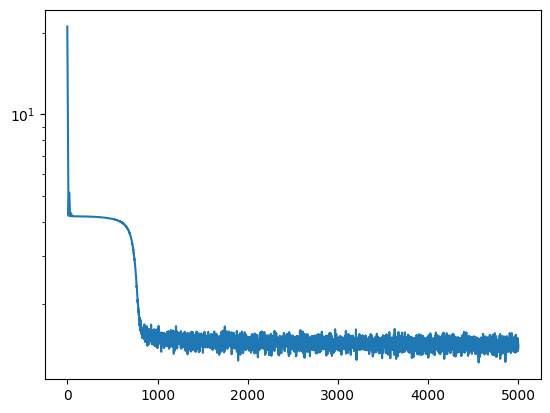

In [89]:
total_loss = model1.total_loss
plt.plot(np.array(total_loss) - 64/45 + 256/45, label='Total loss')
plt.yscale('log')
plt.show()

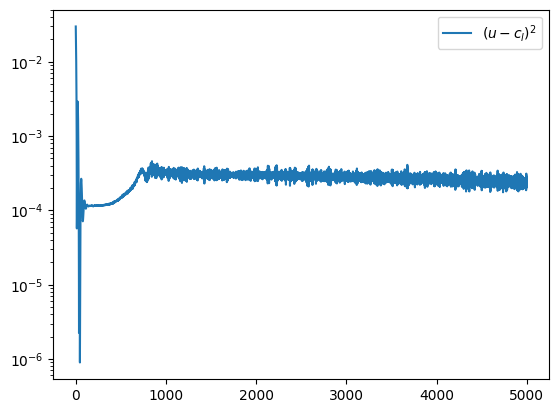

In [90]:
plt.plot(model1.boundary_loss, label=r'$(u - c_l)^2$')
plt.yscale('log')
plt.legend()

In [102]:
import fenics
def asses_solution(example: ExampleOne, model_name: str, grid_size: int):
    mesh_coordinates = (fenics.RectangleMesh(fenics.Point(-1, -1), fenics.Point(1, 1), grid_size, grid_size)).coordinates()
    evaluation_domain_points = torch.FloatTensor(mesh_coordinates).to(device)
    evaluation_domain_points.requires_grad = True

    model = example.model
    model.eval()

    u_pred = model(evaluation_domain_points)
    u_exact = (example.u(evaluation_domain_points.cpu()).unsqueeze(1)).to(device)
    u_pred_reshaped = plots.reshape_tensor_to_cpu(u_pred, grid_size)
    u_exact_reshaped = plots.reshape_tensor_to_cpu(u_exact, grid_size)

    du_pred_x1, du_pred_x2 = plots.partial_derivative_2D(u=u_pred,x=evaluation_domain_points)
    du_exact_x1, du_exact_x2 = example.du_x1_exact(evaluation_domain_points), example.du_x2_exact(evaluation_domain_points) 
    du_pred_x1_reshaped, du_pred_x2_reshaped = plots.reshape_tensor_to_cpu(du_pred_x1, grid_size), plots.reshape_tensor_to_cpu(du_pred_x2, grid_size)
    du_exact_x1_reshaped, du_exact_x2_reshaped = plots.reshape_tensor_to_cpu(du_exact_x1, grid_size), plots.reshape_tensor_to_cpu(du_exact_x2, grid_size)

    mae = plots.compute_mae(plots.to_cpu(u_pred), plots.to_cpu(u_exact))
    err_relative_l2 = plots.compute_l2_relative_error(u_pred, u_exact)
    err_relative_h1 = plots.compute_h1_relative_error(u_pred, u_exact, evaluation_domain_points)

    fig0 = plots.plot_config1(u_pred_reshaped, u_exact_reshaped)
    fig1 = plots.plot_config1(du_pred_x1_reshaped, du_exact_x1_reshaped)
    fig2 = plots.plot_config1(du_pred_x2_reshaped, du_exact_x2_reshaped)


Gradient computation: dim ok
Mean absolute error: 0.005210183560848236
l2_relative_error: 0.012673146528520678, l2_u_true: 52.79999923706055, l2_u_pred: 52.91851043701172
h1_relative_error: 0.058210171785368255, h1_u_true: 130.96673583984375, h1_u_pred: 128.60316467285156


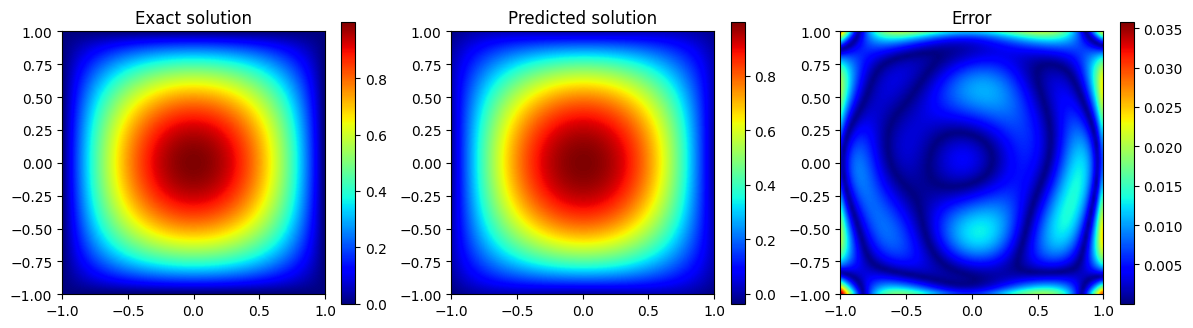

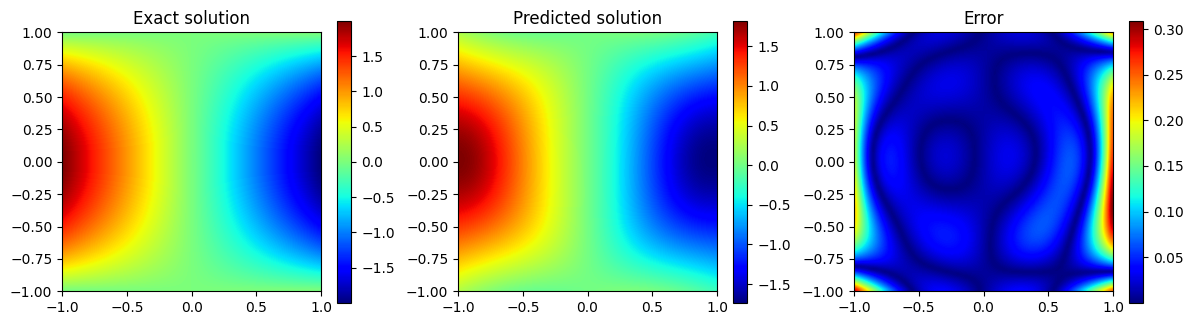

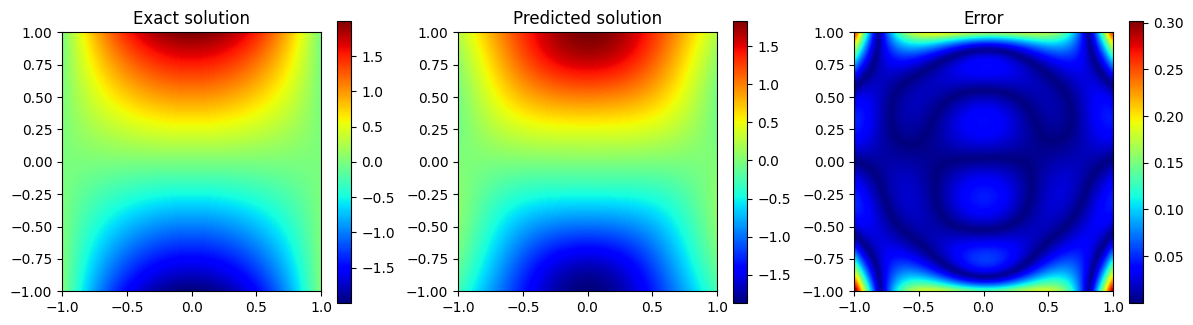

In [103]:
asses_solution(model1, model_name, 99)